Import functions 

In [7]:
#%matplotlib widget
import pycbc
from pycbc import waveform, conversions, filter, types, distributions, detector, psd
import matplotlib.pyplot as plt
import numpy as np
import mass as mass
import functions as func
import injections as inj
import scipy
import seaborn as sns
import importlib
from random import randrange
import time
import h5py
import matplotlib.gridspec as gridspec
from scipy.interpolate import griddata
import lal
lal.ClobberDebugLevel(0)

#plt.rcParams.update({
#    "text.usetex": True})
importlib.reload(func)
importlib.reload(inj)
print(conversions.tau0_from_mass1_mass2(3.0, 3.0, 15.0))

95.45800965419659


Read the Template Bank and initialize some variables

In [10]:
delta_f = 1/32
delta_t = 1.0/2048
f_min  = 10.0

start = time.time()
tb = func.read_tb("banks/ZDHP/combined_bank.hdf", f_min)
end = time.time()
#func.get_mass_ranges_from_TB(tb)
print(conversions.tau0_from_mass1_mass2(5.0, 1.0, 15.0), len(tb), '\n TB reading time', end-start)

Template bank -- banks/ZDHP/combined_bank.hdf
171.82441737755386 243178 
 TB reading time 6.556130886077881


Read injections from a file

/work/rahul.dhurkunde/4ogc/lib/python3.7/site-packages/IPython/core/pylabtools.py:151: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


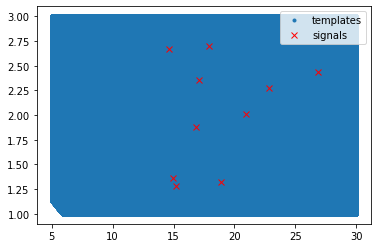

No of signals 10


In [8]:
nsignal = 10
approximant_sg = 'IMRPhenomD'
approximant_tb1 = 'IMRPhenomD'
HMs = False     #Only for signals as of now

sg = []
for k in range(1):
    filename = 'injections/100000_inj/aligned_injections/%s.hdf' %k
    sg = sg + inj.read_injections_HDF(filename, nsignal, f_min)
    
print()    
tb_m1 = [x.m1 for x in tb][:-1000000]
tb_m2 = [x.m2 for x in tb][:-1000000]
plt.plot(tb_m1, tb_m2, '.', label='templates')
sg_m1 = [x.m1 for x in sg]
sg_m2 = [x.m2 for x in sg]
plt.plot(sg_m1, sg_m2, 'x', color='red', label = 'signals')
plt.legend()
plt.show()
print('No of signals', len(sg))

Tau distributions

In [ ]:
sg_tau = np.array([x.tau0 for x in sg])
tb_tau = np.array([x.tau0 for x in tb1])
plt.hist(tb_tau, density = True, bins = 20, label = 'templates')
plt.hist(sg_tau, density = True, label = 'signal')
plt.xlabel('Tau')
plt.legend()
plt.show()
print('Extreme taus of templates', min(tb_tau), max(tb_tau))
print('Extreme taus of signal', min(sg_tau), max(sg_tau))

Read FULL bank matches from files

In [ ]:
tau_crawl = 'injections/tau_files/tau_crawl_50000_aligned.txt'
tau_tolerance = 0.3
tau_bin_edges = np.loadtxt(tau_crawl)[:,0]
tau_bin_statistic = np.loadtxt(tau_crawl)[:,1]
tau_func = func.fit_tau_envelope(tau_bin_edges, tau_bin_statistic, tau_tolerance)

#tau_func = func.flat_tau_envelope(1.5, 100.0, nbins_tau_threshold)

Compute match with the templates having a tau0 mismatch (w.r.t signal) within a tolerance  

In [ ]:
detect = detector.Detector('H1')
tau0_threshold = 0.5
signal_matches = []
length = int(1.0/(delta_f*delta_t*2)) + 1
PSD = psd.analytical.aLIGOZeroDetHighPower(length, delta_f, f_min)

diff_match_ff = []
tau_diff = []
recovered_tau0 = []
start = time.time()
for n in range(nsignal):
    #Check for tau0 of templates
    #n = 17
    temp_indices = func.check_tau0_for_template_generation(tb, sg[n], tau0_threshold)
    print('Injection', n, 'has templates around', len(temp_indices))
    #matches = func.compute_match(tb1, sg[n], PSD, temp_indices, delta_f, f_min, detect, approximant_tb1, approximant_sg, HMs)
    #signal_matches.append(np.max(matches))
    #recovered_tau0.append(tb1[temp_indices[np.argmax(matches)]].tau0)    
    
    #filename = 'matches/full_matches/TF2_%i.hdf' %n
    #func.save_matches_HDF(matches, temp_indices, filename)
    #print('Execution time = ', end - start, 'no.of templates', len(temp_indices))
#print(signal_matches)    

Compare the FF after introducing a tau-threshold

Scatter plot with colors indicating the match values

In [ ]:
fig1, ax1 = plt.subplots()

sg_m1 = [x.m1 for x in sg]
sg_m2 = [x.m2 for x in sg]    
#im = plt.tricontourf(sg_m1, sg_m2, signal_matches)
im = plt.scatter(sg_m1, sg_m2, c = signal_matches)
#plt.plot(sg_m1, sg_m2, 'x', color='red')
fig1.colorbar(im)
plt.xlabel('$m_1$')
plt.ylabel('$m_2$')
plt.title('FF across the complete bank')
plt.savefig('plots/ff_complete_bank_50.png', dpi = 600)
print(min(signal_matches))

In [ ]:
axes = gridspec.GridSpec(2,1)
plt.figure()

sg_m1 = [x.m1 for x in sg]
sg_m2 = [x.m2 for x in sg]    


ax1 = plt.subplot(axes[0,0])
im1 = plt.scatter(sg_m1, sg_m2, c = signal_matches)
plt.colorbar(im1)

ax2 = plt.subplot(axes[1,0])
im2 = plt.scatter(sg_m1, sg_m2, c = ff_array)
plt.colorbar(im2)
plt.xlabel('$m_1$')
plt.ylabel('$m_2$')
print(max(signal_matches))

In [ ]:
start = time.time()
dot_products = func.real_imag_dot_product(sg, PSD, f_min, delta_f, approximant_sg, nsignal)
end = time.time()
print('Exec time', end-start)
#xi = np.linspace(min(sg_m1),max(sg_m1),100)
#yi = np.linspace(min(sg_m2),max(sg_m2),100)
#zi = griddata((sg_m1, sg_m2), dot_products, (xi[None,:], yi[:,None]), method='linear')
#plt.pcolormesh(xi, yi, zi)
fig3, ax3 = plt.subplots() 
#im = plt.tricontourf(sg_m1, sg_m2, dot_products)
im3 = plt.scatter(sg_m1, sg_m2, c = dot_products)
#print(dot_products)
fig3.colorbar(im3)
plt.savefig('hplus_hcross.png', dpi=600)

Distribution of match across the template (tau0)

In [ ]:
tb_taus = np.array([x.tau0 for x in tb])
yolo = []
for i in range(nsignal):
    yolo.append(np.abs(ff_array[i] - signal_matches[i]))
#plt.plot(tb_taus, match_array[1], '.')
#plt.plot(tb_taus[np.argmax(match_array[0])], np.max(match_array[0]), 'x', color = 'red', label = 'Best match')
plt.scatter(sg_tau0, yolo)
plt.xlabel('Tau0')
plt.ylabel('Match')
plt.title('Match of a single signal with every template')
#plt.legend()

In [ ]:
n, bins = np.histogram(signal_matches, density = True, bins=50)
cumulative = np.cumsum(n)*(bins[1]-bins[0])
print(len(cumulative), len(bins))
plt.yscale('log')
plt.plot(bins[:-1], cumulative)
plt.xlabel('FF')
plt.ylabel('Cumulative probability')
plt.grid()
plt.show()